In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
pd.options.display.max_columns=999
df = pd.read_csv('Untitled spreadsheet - Sheet1.csv').dropna()
#df = df.drop('Unnamed: 3', 1)
df = df.dropna()
borders = []
for i in df['Borders']:
    borders.append(i.split('/'))
within = []
for i in df['Within']:
    within.append(i.split('/'))
df['Borders'] = borders
df['Within'] = within
df2 = df.drop(0)
borders = []
for n in df.index:
    x = df.loc[n]['Name of country']
    for i in df.loc[n]['Borders']:
        borders.append([x,i])
borders = pd.DataFrame(borders)
borders = borders.drop([0,1]).reset_index().drop('index',1)
# quality of life indicators
cpi = pd.read_csv('cpi.csv')
cpi = cpi[['Country','2015 cpi']]
cpi = cpi.replace('-',np.nan)
cpi['2015 cpi'] = [float(x) for x in cpi['2015 cpi']]
edbi = pd.read_csv('edbiscores.csv')
homicide = pd.read_csv('homicide.csv')
pfi = pd.read_csv('pfi.csv')[['Country','Score']]
pfi.columns = ['Country','2018 pfi']
pfi['2018 pfi'] = [float(x) for x in pfi['2018 pfi']]
homicide.columns = ['Country','Region','Subregion','Homicide Rate','Homicide County','Year','Source']
qol = pd.merge(cpi,pfi,on='Country')
qol = pd.merge(qol,edbi,on='Country')
qol = pd.merge(qol, homicide, on='Country')
qol['score'] = qol['2015 cpi'] / qol['2018 pfi'] * qol['DB 2019']
qol.head()
#GDP and Population
data = pd.read_csv('world_indicators_all_years.csv')
data = data[data['Time'] == '2016']
data = data.replace('Iran, Islamic Rep.','Iran').replace('Korea, Dem. People’s Rep.',"Democratic People's Republic of Korea").replace('Lao PDR','Laos').replace('Korea, Rep.','Korea,South').replace('Macedonia, FYR','Macedonia').replace('Myanmar','Myanmar (Burma)').replace('Russian Federation','Russia').replace('Slovak Republic','Slovakia').replace('Syrian Arab Republic','Syria').replace('Venezuela, RB','Venezuela').replace('Yemen, Rep.','Yemen')
data1 = data[['Country Name', 'Population, total [SP.POP.TOTL]','Population growth (annual %) [SP.POP.GROW]','GDP (current US$) [NY.GDP.MKTP.CD]', 'GDP per capita (current US$) [NY.GDP.PCAP.CD]']]
data1 = data1.replace('..',np.nan)
for x in [*data1.columns][1:]:
    data1[x] = [float(i) for i in data1[x]]
data1['Population, total [SP.POP.TOTL]'] = [float(n) for n in data1['Population, total [SP.POP.TOTL]']]
data1 = pd.merge(qol,data1,left_on='Country',right_on='Country Name')
#treaties
schengen = ['Austria','Belgium','Czech Republic','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Iceland','Italy','Latvia','Liechtenstein','Lithuania','Luxembourg','Malta','Netherlands','Monaco','Norway','Poland','Portugal','San Marino','Slovakia','Slovenia','Spain','Sweden','Switzerland','Vatican City']
common = ['Ireland','United Kingdom']
unionstate = ['Russia','Belarus']
peaceandfriendship = ['India','Bhutan','Nepal']
ca4 = ['El Salvador','Honduras','Guatemala','Nicaragua']
tasman = ['Australia','New Zealand']
andean = ['Bolivia','Ecuador','Colombia','Peru']
caricom = ['Antigua and Barbuda','Barbados', 'Belize', 'Dominica', 'Grenada','Guyana','Jamaica','Saint Kitts and Nevis','Saint Lucia','Saint Vincent and the Grenadines','Suriname','Trinidad and Tobago']
gcc = ['Saudi Arabia','Oman','Kuwait','United Arab Emirates','Bahrain']
eac = ['Kenya','Tanzania','Uganda','South Sudan','Rwanda','Burundi']
table = [schengen+common+unionstate+peaceandfriendship+ca4+tasman+andean+caricom+gcc+eac,['Schengen'] * len(schengen) + ['Common'] * len(common) + ['Union State'] * len(unionstate) + ['Peace and Friendship'] * len(peaceandfriendship) + ['Central America 4'] * len(ca4) + ['Trans-Tasman Agreement'] * len(tasman) + ['Andean Community'] * len(andean) + len(caricom) * ['Caricom'] + len(gcc) * ['Gulf Cooperation Council'] + ['East African Community'] * len(eac)]
treaties = pd.DataFrame(table).transpose()
treaties.columns = ['Country','Treaty']
notreaty = pd.DataFrame([*set(treaties['Country'])^set(data1['Country Name'])])
notreaty['Treaty'] = None
notreaty.columns = ['Country','Treaty']
treaties = pd.concat([notreaty,treaties])
data1 = pd.merge(data1,treaties)
#bring it all together
test1 = pd.merge(borders,data1,left_on=0,right_on='Country Name')
test1.columns = ['Country 1','Country 2','C','2015 cpi', '2018 pfi', 'DB 2018',
       'DB 2019', 'Region', 'Subregion', 'Homicide Rate', 'Homicide County',
       'Year', 'Source', 'score', 'Country Name','Population 1','Population growth 1','GDP 1','GDP per capita 1','Treaty 1']
test1['Country 2'] = [s.rstrip(" ").lstrip(' ') for s in test1['Country 2']]
test2 = pd.merge(test1,data1,left_on='Country 2',right_on='Country Name')
#More statistics
test2.columns = ['Country 1', 'Country 2', 'C', '2015 cpi_x', '2018 pfi_x', 'DB 2018_x', 'DB 2019_x', 'Region_x', 'Subregion_x',
       'Homicide Rate_x', 'Homicide County_x', 'Year_x', 'Source_x', 'score_x',
       'Country Name_x', 'Population 1', 'Population growth 1', 'GDP 1',
       'GDP per capita 1','Treaty 1', 'Country', '2015 cpi_y', '2018 pfi_y', 'DB 2018_y', 'DB 2019_y', 'Region_y', 'Subregion_y',
       'Homicide Rate_y', 'Homicide County_y', 'Year_y', 'Source_y', 'score_y',
       'Country Name_y', 'Population 2',
       'Population growth 2','GDP 2','GDP per capita 2','Treaty 2']
test2['Population difference'] = test2['Population 1'] / test2['Population 2']
test2['Population growth difference'] = test2['Population growth 1']/ test2['Population growth 2']
test2['GDP difference'] = test2['GDP 1'] / test2['GDP 2']
test2['GDP per capita difference'] = test2['GDP per capita 1'] / test2['GDP per capita 2']
df1 = test2
test2['Population difference'] = [1/x if x > 1 else x for x in test2['Population difference'] ]
test2['Population growth difference'] = [1/x if x > 1 else x for x in test2['Population growth difference']]
test2['GDP difference'] = [1/x if x > 1 else x for x in test2['GDP difference']]
test2['GDP per capita difference'] = [1/x if x > 1 else x for x in test2['GDP per capita difference']]
test2 = pd.merge(test2,df2, left_on='Country 1', right_on='Name of country').drop('Borders',1)
test2['GDP product'] = test2['GDP 1'] *test2['GDP 2']
test2['GDP per capita in both'] = (test2['GDP 1'] + test2['GDP 2']) / (test2['Population 1'] + test2['Population 2'])
test2 = test2.drop_duplicates('GDP product').reset_index()
df1['cpi difference'] = df1['2015 cpi_x'] / df1['2015 cpi_y']
#df1['cpi difference'] = [1/x if x > 1 for x in df1['cpi difference'] else x]
df1['cpi difference'] = [1/x if x > 1 else x for x in df1['cpi difference']]
df1['db difference'] = df1['DB 2019_x'] / df1['DB 2019_y']
df1['db difference'] = [1/x if x > 1 else x for x in df1['db difference']]
df1['pfi difference'] = df1['2018 pfi_x'] / df1['2018 pfi_y']
df1['pfi difference'] = [1/x if x > 1 else x for x in df1['pfi difference']]
df1['homicide difference'] = df1['Homicide Rate_x'] / df1['Homicide Rate_y']
df1['homicide difference'] = [1/x if x > 1 else x for x in df1['homicide difference']]
df1['Country Similarity'] = (df1['cpi difference']+df1['db difference']+df1['pfi difference']+df1['homicide difference']) /4
df1['average cpi'] = df1[['2015 cpi_x','2015 cpi_y']].mean(axis=1)
df1['average db'] = df1[['DB 2019_x','DB 2019_y']].mean(axis=1)
df1['average pfi'] = df1[['2018 pfi_x','2018 pfi_y']].mean(axis=1)
df1['average homicide'] = df1[['Homicide Rate_x','Homicide Rate_y']].mean(axis=1)
df1['Border Status'] = np.where(df1['Treaty 1'] == df1['Treaty 2'], 'Open', 'Closed')
df1['Combined Population'] = df1['Population 1'] + df1['Population 2']
df1['viability'] = df1['average cpi'] * df1['average db'] / (df1['average pfi'] * df1['average homicide'])
df1 = df1.drop_duplicates('Combined Population').sort_values('viability', ascending = False).reset_index().drop('index',1)
df1.head()

/var/folders/qc/qdwcn8y54q9bc60c6s4xrk1c0000gn/T/ipykernel_49063/754440130.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  borders = borders.drop([0,1]).reset_index().drop('index',1)
/var/folders/qc/qdwcn8y54q9bc60c6s4xrk1c0000gn/T/ipykernel_49063/754440130.py:90: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test2 = pd.merge(test2,df2, left_on='Country 1', right_on='Name of country').drop('Borders',1)
/var/folders/qc/qdwcn8y54q9bc60c6s4xrk1c0000gn/T/ipykernel_49063/754440130.py:111: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df1 = df1.drop_duplicates('Combined Population').sort_values('viability', ascending = False).reset_index().drop('index',1)


Country 1     Country 2        C  2015 cpi_x  2018 pfi_x  DB 2018_x  \
0   Algeria       Tunisia  Algeria        36.0       43.13      47.59   
1     Benin  Burkina Faso    Benin        37.0       30.16      51.29   
2   Algeria         Niger  Algeria        36.0       43.13      47.59   
3     Benin         Niger    Benin        37.0       30.16      51.29   
4   Algeria    Mauritania  Algeria        36.0       43.13      47.59   

   DB 2019_x Region_x      Subregion_x  Homicide Rate_x  Homicide County_x  \
0      49.65   Africa  Northern Africa             1.36              542.0   
1      51.42   Africa   Western Africa             6.18              654.0   
2      49.65   Africa  Northern Africa             1.36              542.0   
3      51.42   Africa   Western Africa             6.18              654.0   
4      49.65   Africa  Northern Africa             1.36              542.0   

   Year_x      Source_x    score_x Country Name_x  Population 1  \
0  2015.0           CTS  41.442152        Algeria    40606052.0   
1  2015.0  WHO Estimate  63.081565          Benin    10872298.0   
2  2015.0           CTS  41.442152        Algeria    40606052.0   
3  2015.0  WHO Estimate  63.081565          Benin    10872298.0   
4  2015.0           CTS  41.442152        Algeria    40606052.0   

   Population growth 1         GDP 1  GDP per capita 1 Treaty 1       Country  \
0             1.825463  1.590491e+11       3916.881571     None       Tunisia   
1             2.763534  8.583031e+09        789.440411     None  Burkina Faso   
2             1.825463  1.590491e+11       3916.881571     None         Niger   
3             2.763534  8.583031e+09        789.440411     None         Niger   
4             1.825463  1.590491e+11       3916.881571     None    Mauritania   

   2015 cpi_y  2018 pfi_y  DB 2018_y  DB 2019_y Region_y      Subregion_y  \
0        38.0       30.91      64.60      66.11   Africa  Northern Africa   
1        38.0       23.33      51.45      51.57   Africa   Western Africa   
2        34.0       27.40      52.48      53.72   Africa   Western Africa   
3        34.0       27.40      52.48      53.72   Africa   Western Africa   
4        31.0       29.09      51.07      51.99   Africa   Western Africa   

   Homicide Rate_y  Homicide County_y  Year_y      Source_y    score_y  \
0             3.05              332.0  2012.0           WHO  81.274021   
1             0.37               67.0  2015.0           NSO  83.997428   
2             4.44              788.0  2012.0           WHO  66.659854   
3             4.44              788.0  2012.0           WHO  66.659854   
4             9.94              416.0  2015.0  WHO Estimate  55.403575   

  Country Name_y  Population 2  Population growth 2         GDP 2  \
0        Tunisia    11403248.0             1.142911  4.206255e+10   
1   Burkina Faso    18646433.0             2.915614  1.169324e+10   
2          Niger    20672987.0             3.826066  7.528388e+09   
3          Niger    20672987.0             3.826066  7.528388e+09   
4     Mauritania     4301018.0             2.798060  4.739299e+09   

   GDP per capita 2 Treaty 2  Population difference  \
0       3688.646375     None               0.280826   
1        627.103079     None               0.583077   
2        364.165462     None               0.509111   
3        364.165462     None               0.525918   
4       1101.901627     None               0.105921   

   Population growth difference  GDP difference  GDP per capita difference  \
0                      0.626093        0.264463                   0.941730   
1                      0.947840        0.734017                   0.794364   
2                      0.477112        0.047334                   0.092973   
3                      0.722291        0.877125                   0.461296   
4                      0.652403        0.029798                   0.281321   

   cpi difference  db difference  pfi difference  homicide difference  \
0       

In [3]:
border = pd.read_csv("border_length.csv")
border = border.fillna(method='ffill')
border = border[border['length']> 0].drop_duplicates()
neighbor = [x.replace('\xa0','').split(':') for x in border['country2']]
length = [x[1].strip(' ').split('km')[0].replace(',','') for x in neighbor]
country = [x[0].strip(' ') for x in neighbor]
length = [float(x) for x in length]
border['country2'] = country
border['length2'] = length
border['Country'] = [x.strip('\xa0').strip(' ') for x in border['Country']]
border

Country    length distinct land borders  \
0            People's Republic of China  22147.00                    17   
1            People's Republic of China  22147.00                    17   
2            People's Republic of China  22147.00                    17   
3            People's Republic of China  22147.00                    17   
4            People's Republic of China  22147.00                    17   
..                                  ...       ...                   ...   
673                          San Marino     39.00                     1   
674                           Hong Kong     30.00                     1   
675                              Monaco      4.40                     1   
676                        Vatican City      3.20                     1   
677  Macau (People's Republic of China)      0.34                     1   

     distinct land neighbors                    country2  length2  
0                       14.0                 Afghanistan    76.00  
1                       14.0                      Bhutan   470.00  
2                       14.0                       India  3380.00  
3                       14.0                  Kazakhstan  1533.00  
4                       14.0                 North Korea  1416.00  
..                       ...                         ...      ...  
673                      1.0                       Italy    39.00  
674                      1.0  People's Republic of China    30.00  
675                      1.0                      France     4.40  
676                      1.0                       Italy     3.20  
677                      1.0  People's Republic of China     0.34  

[676 rows x 6 columns]

In [4]:
data1.shape

(146, 18)

In [5]:
border.sort_values('length2').drop_duplicates('length2')

Country    length distinct land borders  \
45                                India  14209.00                    10   
133                              Zambia   5667.00                     8   
677  Macau (People's Republic of China)      0.34                     1   
476                               Spain   1918.00                     9   
676                        Vatican City      3.20                     1   
..                                  ...       ...                   ...   
39                                India  14209.00                    10   
69                             Mongolia   8220.00                     2   
64                            Argentina   9665.00                     6   
21                               Russia  20017.00                    15   
46                        United States  12034.00                     5   

     distinct land neighbors                    country2   length2  
45                       7.0                   Sri Lanka     0.045  
133                      8.0                    Botswana     0.150  
677                      1.0  People's Republic of China     0.340  
476                      5.0                   Gibraltar     1.200  
676                      1.0                       Italy     3.200  
..                       ...                         ...       ...  
39                       7.0                  Bangladesh  4053.000  
69                       2.0  People's Republic of China  4677.000  
64                       5.0                       Chile  5300.000  
21                      14.0                  Kazakhstan  6846.000  
46                       2.0                      Canada  8893.000  

[282 rows x 6 columns]

In [6]:
replacement = {'Denmark (constituent country)': 'Denmark',
              'Denmark, Kingdom of': 'Denmark',
              "People's Republic of China":'China',
              'France (including French overseas departments, collectivities, and territories)':'France',
               'Netherlands (constituent country)':'Netherlands',
               'Netherlands, Kingdom of': 'Netherlands',}

In [7]:
border['Country'] = [replacement[x] if x in replacement else x for x in border['Country']]

In [8]:
set(border['Country']) - set(data1['Country'])

{'Abkhazia',
 'Andorra',
 'Bosnia and Herzegovina',
 'Brunei',
 "Côte d'Ivoire",
 'Democratic Republic of the Congo',
 'East Timor',
 'Egypt',
 'Eswatini',
 'France, Metropolitan',
 'Guinea-Bissau',
 'Haiti',
 'Hong Kong',
 'Iran',
 'Kyrgyzstan',
 'Laos',
 'Liechtenstein',
 "Macau (People's Republic of China)",
 'Monaco',
 'Morocco',
 'Myanmar',
 'North Korea',
 'North Macedonia',
 'Palestine',
 'Republic of the Congo',
 'Russia',
 'San Marino',
 'Slovakia',
 'South Korea',
 'South Ossetia',
 'Suriname',
 'Syria',
 'The Gambia',
 'Turkmenistan',
 'United Kingdom (plus British Overseas Territories and Crown Dependencies)',
 'Vatican City',
 'Venezuela',
 'Western Sahara',
 'Yemen',
 '→includes:'}

In [9]:
set(data1['Country']) - set(border['Country'])

{'Australia',
 'Bahrain',
 'Comoros',
 'Fiji',
 'Iceland',
 'Jamaica',
 'Japan',
 'Madagascar',
 'Maldives',
 'Malta',
 'Mauritius',
 'New Zealand',
 'Philippines',
 'Samoa',
 'Seychelles',
 'Singapore',
 'Sri Lanka',
 'Tonga',
 'Trinidad and Tobago'}

In [10]:
border

Country    length distinct land borders  \
0                                 China  22147.00                    17   
1                                 China  22147.00                    17   
2                                 China  22147.00                    17   
3                                 China  22147.00                    17   
4                                 China  22147.00                    17   
..                                  ...       ...                   ...   
673                          San Marino     39.00                     1   
674                           Hong Kong     30.00                     1   
675                              Monaco      4.40                     1   
676                        Vatican City      3.20                     1   
677  Macau (People's Republic of China)      0.34                     1   

     distinct land neighbors                    country2  length2  
0                       14.0                 Afghanistan    76.00  
1                       14.0                      Bhutan   470.00  
2                       14.0                       India  3380.00  
3                       14.0                  Kazakhstan  1533.00  
4                       14.0                 North Korea  1416.00  
..                       ...                         ...      ...  
673                      1.0                       Italy    39.00  
674                      1.0  People's Republic of China    30.00  
675                      1.0                      France     4.40  
676                      1.0                       Italy     3.20  
677                      1.0  People's Republic of China     0.34  

[676 rows x 6 columns]

In [11]:
bor = pd.merge(
    pd.merge(border,
             data1,
             on='Country'),
    data1,
    left_on='country2',
    right_on='Country')

In [12]:
bor

Country_x   length distinct land borders  distinct land neighbors  \
0             China  22147.0                    17                     14.0   
1          Pakistan   6774.0                     4                      4.0   
2        Uzbekistan   6221.0                    11                      5.0   
3        Tajikistan   3651.0                     7                      4.0   
4             China  22147.0                    17                     14.0   
..              ...      ...                   ...                      ...   
400          Latvia   1150.0                     4                      4.0   
401          Israel   1017.0                     4                      5.0   
402         Ireland    499.0                     1                      1.0   
403  United Kingdom    499.0                     1                      1.0   
404      Luxembourg    359.0                     3                      3.0   

           country2  length2  2015 cpi_x  2018 pfi_x  DB 2018_x  DB 2019_x  \
0       Afghanistan     76.0        37.0       78.29      65.00      73.64   
1       Afghanistan   2430.0        30.0       43.24      52.78      55.31   
2       Afghanistan    137.0        19.0       60.84      66.32      67.40   
3       Afghanistan   1206.0        26.0       50.06      57.03      57.11   
4            Bhutan    470.0        37.0       78.29      65.00      73.64   
..              ...      ...         ...         ...        ...        ...   
400         Estonia    339.0        55.0       19.63      79.26      79.59   
401         Lebanon     79.0        61.0       30.26      72.59      73.23   
402  United Kingdom    499.0        75.0       14.59      79.42      78.91   
403  United Kingdom    499.0        81.0       23.25      82.32      82.65   
404         Belgium    148.0        81.0       14.72      69.01      69.01   

    Region_x      Subregion_x  Homicide Rate_x  Homicide County_x  Year_x  \
0       Asia     Eastern Asia             0.62             8634.0  2016.0   
1       Asia    Southern Asia             4.41             8516.0  2016.0   
2       Asia     Central Asia             3.00              831.0  2008.0   
3       Asia     Central Asia             1.61              126.0  2011.0   
4       Asia     Eastern Asia             0.62             8634.0  2016.0   
..       ...              ...              ...                ...     ...   
400   Europe  Northern Europe             3.36               67.0  2015.0   
401     Asia     Western Asia             1.36              110.0  2015.0   
402   Europe  Northern Europe             0.80               38.0  2016.0   
403   Europe  Northern Europe             1.20              791.0  2016.0   
404   Europe   Western Europe             0.72                4.0  2014.0   

             Source_x     score_x  Country Name_x  \
0    NSO Adjusted/NSO   34.802401           China   
1                 NSO   38.374191        Pakistan   
2          TSMNEE/NSO   21.048652      Uzbekistan   
3          TSMNEE/CTS   29.661606      Tajikistan   
4    NSO Adjusted/NSO   34.802401           China   
..                ...         ...             ...   
400         UNSDC/CTS  222.997962          Latvia   
401       NSO/CTS/SDG  147.621613          Israel   
402        NP/NSO/CTS  405.637423         Ireland   
403               CTS  287.941935  United Kingdom   
404     EUR/UNECE/CTS  379.742527      Luxembourg   

     Population, total [SP.POP.TOTL]_x  \
0                         1.378665e+09   
1                         1.932035e+08   
2                         3.184820e+07   
3                         8.734951e+06   
4                         1.378665e+09   
..                                 ...   
400                       1.960424e+06   
401                       8.547100e+06   
402                       4.773095e+06   
403                       6.563724e+07   
404                       5.829720e+05   

     Population growth (annual %) [SP.POP.GROW]_x  \
0   

In [13]:
bor['cpi difference'] = bor['2015 cpi_x'] / bor['2015 cpi_y']
#bor['cpi difference'] = [1/x if x > 1 for x in bor['cpi difference'] else x]
bor['cpi difference'] = [1/x if x > 1 else x for x in bor['cpi difference']]
bor['db difference'] = bor['DB 2019_x'] / bor['DB 2019_y']
bor['db difference'] = [1/x if x > 1 else x for x in bor['db difference']]
bor['pfi difference'] = bor['2018 pfi_x'] / bor['2018 pfi_y']
bor['pfi difference'] = [1/x if x > 1 else x for x in bor['pfi difference']]
bor['homicide difference'] = bor['Homicide Rate_x'] / bor['Homicide Rate_y']
bor['homicide difference'] = [1/x if x > 1 else x for x in bor['homicide difference']]
bor['Country Similarity'] = (bor['cpi difference']+bor['db difference']+bor['pfi difference']+bor['homicide difference']) /4
bor['average cpi'] = bor[['2015 cpi_x','2015 cpi_y']].mean(axis=1)
bor['average db'] = bor[['DB 2019_x','DB 2019_y']].mean(axis=1)
bor['average pfi'] = bor[['2018 pfi_x','2018 pfi_y']].mean(axis=1)
bor['average homicide'] = bor[['Homicide Rate_x','Homicide Rate_y']].mean(axis=1)
bor['Status'] = np.where(bor['Treaty_x'] == bor['Treaty_y'], 'Open', 'Closed')
bor['Combined Population'] = bor['Population, total [SP.POP.TOTL]_y'] + bor['Population, total [SP.POP.TOTL]_x']
bor['viability'] = bor['average cpi'] * bor['average db'] / (bor['average pfi'] * bor['average homicide'])
bor

Country_x   length distinct land borders  distinct land neighbors  \
0             China  22147.0                    17                     14.0   
1          Pakistan   6774.0                     4                      4.0   
2        Uzbekistan   6221.0                    11                      5.0   
3        Tajikistan   3651.0                     7                      4.0   
4             China  22147.0                    17                     14.0   
..              ...      ...                   ...                      ...   
400          Latvia   1150.0                     4                      4.0   
401          Israel   1017.0                     4                      5.0   
402         Ireland    499.0                     1                      1.0   
403  United Kingdom    499.0                     1                      1.0   
404      Luxembourg    359.0                     3                      3.0   

           country2  length2  2015 cpi_x  2018 pfi_x  DB 2018_x  DB 2019_x  \
0       Afghanistan     76.0        37.0       78.29      65.00      73.64   
1       Afghanistan   2430.0        30.0       43.24      52.78      55.31   
2       Afghanistan    137.0        19.0       60.84      66.32      67.40   
3       Afghanistan   1206.0        26.0       50.06      57.03      57.11   
4            Bhutan    470.0        37.0       78.29      65.00      73.64   
..              ...      ...         ...         ...        ...        ...   
400         Estonia    339.0        55.0       19.63      79.26      79.59   
401         Lebanon     79.0        61.0       30.26      72.59      73.23   
402  United Kingdom    499.0        75.0       14.59      79.42      78.91   
403  United Kingdom    499.0        81.0       23.25      82.32      82.65   
404         Belgium    148.0        81.0       14.72      69.01      69.01   

    Region_x      Subregion_x  Homicide Rate_x  Homicide County_x  Year_x  \
0       Asia     Eastern Asia             0.62             8634.0  2016.0   
1       Asia    Southern Asia             4.41             8516.0  2016.0   
2       Asia     Central Asia             3.00              831.0  2008.0   
3       Asia     Central Asia             1.61              126.0  2011.0   
4       Asia     Eastern Asia             0.62             8634.0  2016.0   
..       ...              ...              ...                ...     ...   
400   Europe  Northern Europe             3.36               67.0  2015.0   
401     Asia     Western Asia             1.36              110.0  2015.0   
402   Europe  Northern Europe             0.80               38.0  2016.0   
403   Europe  Northern Europe             1.20              791.0  2016.0   
404   Europe   Western Europe             0.72                4.0  2014.0   

             Source_x     score_x  Country Name_x  \
0    NSO Adjusted/NSO   34.802401           China   
1                 NSO   38.374191        Pakistan   
2          TSMNEE/NSO   21.048652      Uzbekistan   
3          TSMNEE/CTS   29.661606      Tajikistan   
4    NSO Adjusted/NSO   34.802401           China   
..                ...         ...             ...   
400         UNSDC/CTS  222.997962          Latvia   
401       NSO/CTS/SDG  147.621613          Israel   
402        NP/NSO/CTS  405.637423         Ireland   
403               CTS  287.941935  United Kingdom   
404     EUR/UNECE/CTS  379.742527      Luxembourg   

     Population, total [SP.POP.TOTL]_x  \
0                         1.378665e+09   
1                         1.932035e+08   
2                         3.184820e+07   
3                         8.734951e+06   
4                         1.378665e+09   
..                                 ...   
400                       1.960424e+06   
401                       8.547100e+06   
402                       4.773095e+06   
403                       6.563724e+07   
404                       5.829720e+05   

     Population growth (annual %) [SP.POP.GROW]_x  \
0   

In [27]:
bor['Border Status'] = bor['Treaty_x'] == bor['Treaty_y']

In [15]:
bor[bor['Status'] == 'Open']

Country_x   length distinct land borders  distinct land neighbors  \
5             India  14209.0                    10                      7.0   
9             Nepal   2926.0                     2                      2.0   
10           Bhutan   1075.0                     2                      2.0   
16            India  14209.0                    10                      7.0   
33             Peru   5536.0                     5                      5.0   
..              ...      ...                   ...                      ...   
399        Portugal   1214.0                     1                      1.0   
400          Latvia   1150.0                     4                      4.0   
402         Ireland    499.0                     1                      1.0   
403  United Kingdom    499.0                     1                      1.0   
404      Luxembourg    359.0                     3                      3.0   

           country2  length2  2015 cpi_x  2018 pfi_x  DB 2018_x  DB 2019_x  \
5            Bhutan    605.0        38.0       43.24      60.60      67.23   
9             India   1690.0        27.0       32.05      59.95      59.63   
10            India    605.0        65.0       30.73      65.88      66.08   
16            Nepal   1690.0        38.0       43.24      60.60      67.23   
33          Bolivia    900.0        36.0       30.27      68.27      68.83   
..              ...      ...         ...         ...        ...        ...   
399           Spain   1214.0        63.0       14.17      76.62      76.55   
400         Estonia    339.0        55.0       19.63      79.26      79.59   
402  United Kingdom    499.0        75.0       14.59      79.42      78.91   
403  United Kingdom    499.0        81.0       23.25      82.32      82.65   
404         Belgium    148.0        81.0       14.72      69.01      69.01   

     Region_x      Subregion_x  Homicide Rate_x  Homicide County_x  Year_x  \
5        Asia    Southern Asia             3.22            42678.0  2016.0   
9        Asia    Southern Asia             2.16              627.0  2016.0   
10       Asia    Southern Asia             1.13                9.0  2016.0   
16       Asia    Southern Asia             3.22            42678.0  2016.0   
33   Americas    South America             7.67             2435.0  2016.0   
..        ...              ...              ...                ...     ...   
399    Europe  Southern Europe             0.64               66.0  2016.0   
400    Europe  Northern Europe             3.36               67.0  2015.0   
402    Europe  Northern Europe             0.80               38.0  2016.0   
403    Europe  Northern Europe             1.20              791.0  2016.0   
404    Europe   Western Europe             0.72                4.0  2014.0   

          Source_x     score_x  Country Name_x  \
5              MOI   59.082794           India   
9          NSO/CTS   50.234321           Nepal   
10         NSO/CTS  139.772210          Bhutan   
16             MOI   59.082794           India   
33             CTS   81.859267            Peru   
..             ...         ...             ...   
399    EUR/CTS/SDG  340.342272        Portugal   
400      UNSDC/CTS  222.997962          Latvia   
402     NP/NSO/CTS  405.637423         Ireland   
403            CTS  287.941935  United Kingdom   
404  EUR/UNECE/CTS  379.742527      Luxembourg   

     Population, total [SP.POP.TOTL]_x  \
5                         1.324171e+09   
9                         2.898277e+07   
10                        7.977650e+05   
16                        1.324171e+09   
33                        3.177384e+07   
..                                 ...   
399                       1.032461e+07   
400                       1.960424e+06   
402                       4.773095e+06   
403                       6.563724e+07   
404                       5.829720e+05   

     Population growth (annual %) [SP.POP.GROW]_x  \
5                           

In [16]:
bor['Status'].value_counts()

Closed    302
Open      103
Name: Status, dtype: int64

In [17]:
bor.sort_values('viability')

Country_x  length distinct land borders  distinct land neighbors  \
386     Honduras  1520.0                     3                      3.0   
389  El Salvador   545.0                     2                      2.0   
126        Sudan  6764.0                     7                      7.0   
155  South Sudan  4797.0                     6                      6.0   
104  South Sudan  4797.0                     6                      6.0   
..           ...     ...                   ...                      ...   
289  Switzerland  1852.0                     8                      5.0   
340      Finland  2690.0                     4                      3.0   
365       Norway  2551.0                     3                      3.0   
341       Sweden  2233.0                     3                      2.0   
343       Norway  2551.0                     3                      3.0   

                     country2  length2  2015 cpi_x  2018 pfi_x  DB 2018_x  \
386               El Salvador    342.0        31.0       45.23      58.13   
389                  Honduras    342.0        39.0       27.78      65.20   
126               South Sudan   1937.0        12.0       71.13      45.09   
155                     Sudan   1937.0        15.0       46.88      33.30   
104  Central African Republic    682.0        15.0       46.88      33.30   
..                        ...      ...         ...         ...        ...   
289                   Austria    164.0        86.0       11.27      75.68   
340                    Norway    736.0        90.0       10.26      80.30   
365                   Finland    736.0        87.0        7.63      82.70   
341                    Norway   1619.0        89.0        8.31      81.27   
343                    Sweden   1619.0        87.0        7.63      82.70   

     DB 2019_x  Region_x      Subregion_x  Homicide Rate_x  Homicide County_x  \
386      58.22  Americas  Central America            56.52             5150.0   
389      65.41  Americas  Central America            82.84             5257.0   
126      48.84    Africa  Northern Africa             5.16             1702.0   
155      35.34    Africa   Eastern Africa            13.90             1504.0   
104      35.34    Africa   Eastern Africa            13.90             1504.0   
..         ...       ...              ...              ...                ...   
289      75.69    Europe   Western Europe             0.54               45.0   
340      80.35    Europe  Northern Europe             1.42               78.0   
365      82.95    Europe  Northern Europe             0.51               27.0   
341      81.27    Europe  Northern Europe             1.08              106.0   
343      82.95    Europe  Northern Europe             0.51               27.0   

     Year_x       Source_x     score_x Country Name_x  \
386  2016.0  OCAVI/NSO/CTS   39.903162       Honduras   
389  2016.0    OAS/CTS/RSC   91.828294    El Salvador   
126  2008.0            CTS    8.239561          Sudan   
155  2012.0             NP   11.307594    South Sudan   
104  2012.0             NP   11.307594    South Sudan   
..      ...            ...         ...            ...   
289  2016.0  UNSDC/EUR/CTS  577.581189    Switzerland   
340  2016.0      UNSDC/CTS  704.824561        Finland   
365  2016.0    SDG/EUR/CTS  945.825688         Norway   
341  2016.0       NCCP/CTS  870.400722         Sweden   
343  2016.0    SDG/EUR/CTS  945.825688         Norway   

     Population, total [SP.POP.TOTL]_x  \
386                          9112867.0   
389                          6344722.0   
126                         39578828.0   
155                         12230730.0   
104                         12230730.0   
..                                 ...   
289                          8372098.0   
340                          5495096.0   
365                          5232929.0   
341                          9903122.0   
343                          5232929.0   

     Population gr

In [38]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','bool']
import statsmodels.discrete.discrete_model as sm
import statsmodels
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
def regression(y, df):
    df = df.select_dtypes(include=numerics).dropna()
    X = df.drop([y], 1)
    y = df[y]
    model = statsmodels.regression.linear_model.OLS(y, X)
    model = model.fit()
    predictions = model.predict(X)
    # Plot the model
    plt.figure(figsize=(8,6))
    plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
    plt.xlabel("Predicted Values - $\hat{y}$")
    plt.ylabel("Actual Values - $y$")
    plt.show()
    print("MSE:", mean_squared_error(y, predictions))
    return model.summary()

/var/folders/qc/qdwcn8y54q9bc60c6s4xrk1c0000gn/T/ipykernel_49063/2618132378.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df.drop([y], 1)


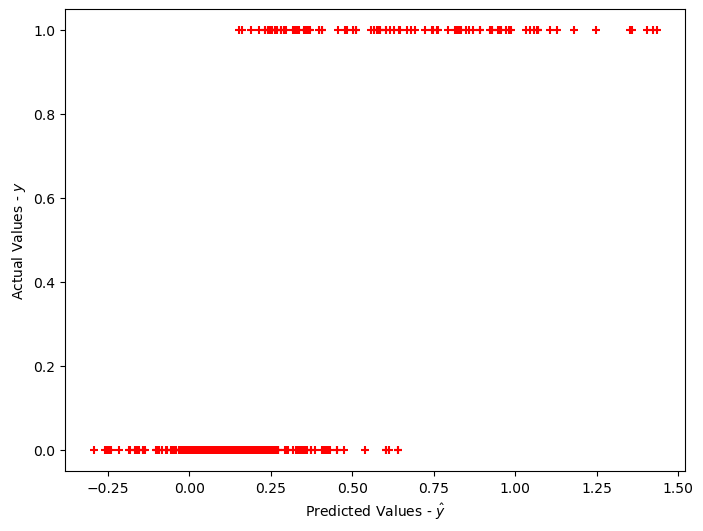

MSE: 0.09794245489714175


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Border Status   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     10.94
Date:                Tue, 13 Jun 2023   Prob (F-statistic):           8.82e-35
Time:                        22:26:02   Log-Likelihood:                -93.639
No. Observations:                 364   AIC:                             251.3
Df Residuals:                     332   BIC:                             376.0
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
length                                          -2.439e-05   1.22e-05     -2.004      0.046   -4.83e-05   -4.47e-07
distinct land neighbors                             0.0087      0.012      0.732      0.464      -0.015       0.032
length2                                         -1.949e-05   2.63e-05     -0.740      0.460   -7.13e-05    3.23e-05
2015 cpi_x                                          0.0006      0.002      0.274      0.784      -0.004       0.005
2018 pfi_x                                         -0.0011      0.002     -0.561      0.575      -0.005       0.003
DB 2018_x                                           0.0153      0.013      1.212      0.226      -0.010       0.040
DB 2019_x                                          -0.0066      0.010     -0.648      0.517      -0.027       0.013
Homicide Rate_x                                     0.0041      0.002      1.784      0.075      -0.000       0.009
Homicide County_x                               -9.564e-07   2.55e-06     -0.376      0.707   -5.97e-06    4.05e-06
Year_x                                             -0.0001      0.008     -0.014      0.989      -0.016       0.016
score_x                                            -0.0005      0.000     -1.383      0.168      -0.001       0.000
Population, total [SP.POP.TOTL]_x                  7.9e-06    2.5e-06      3.164      0.002    2.99e-06    1.28e-05
Population growth (annual %) [SP.POP.GROW]_x        0.0409      0.026      1.571      0.117      -0.010       0.092
GDP (current US$) [NY.GDP.MKTP.CD]_x            -2.023e-14   1.47e-14     -1.380      0.168   -4.91e-14     8.6e-15
GDP per capita (current US$) [NY.GDP.PCAP.CD]_x  4.188e-06    2.2e-06      1.907      0.057   -1.33e-07    8.51e-06
2015 cpi_y                                          0.0017      0.002      0.737      0.462      -0.003       0.006
2018 pfi_y                                         -0.0006      0.002     -0.294      0.769      -0.004       0.003
DB 2018_y                                           0.0084      0.012      0.674      0.501      -0.016       0.033
DB 2019_y                                           0.0002      0.010      0.022      0.983      -0.020       0.020
Homicide Rate_y                                     0.0053      0.002      2.284      0.023       0.001       0.010
Homicide County_y                               -5.275e-06   2.65e-06     -1.991      0.047   -1.05e-05    -6.2e-08
Year_y                                             -0.0001      0.008     -0.013      0.989      -0.016       0.016
score_y                                            -0.0005      0.000     -1.096      0.274      -0.001       0.000
Population, total [SP.POP.TOTL]_y                  7.9e-06    2.5e-

In [39]:
regression('Border Status',bor)

In [48]:
def RFRegressor(y, df):
    X = df.drop([y], 1)
    y = df[y]
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor()
    rf.fit(X, y)
    names = X.dtypes.index
    print("Features sorted by their score:")
    print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
                 reverse=True))
RFRegressor('Border Status',bor.select_dtypes(include=numerics).dropna().drop(['viability'],1))

/var/folders/qc/qdwcn8y54q9bc60c6s4xrk1c0000gn/T/ipykernel_49063/158030853.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  RFRegressor('Border Status',bor.select_dtypes(include=numerics).dropna().drop(['viability'],1))
/var/folders/qc/qdwcn8y54q9bc60c6s4xrk1c0000gn/T/ipykernel_49063/158030853.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df.drop([y], 1)


Features sorted by their score:
[(0.363, 'average cpi'), (0.0747, 'GDP per capita (current US$) [NY.GDP.PCAP.CD]_y'), (0.0602, 'GDP per capita (current US$) [NY.GDP.PCAP.CD]_x'), (0.0578, 'average homicide'), (0.0382, 'Homicide County_x'), (0.0333, 'Homicide County_y'), (0.029, 'length'), (0.0282, 'db difference'), (0.0269, 'average db'), (0.0226, 'homicide difference'), (0.0221, 'Homicide Rate_x'), (0.0191, 'Homicide Rate_y'), (0.0181, 'Population growth (annual %) [SP.POP.GROW]_y'), (0.0155, 'DB 2018_y'), (0.0155, 'Combined Population'), (0.0152, 'Population growth (annual %) [SP.POP.GROW]_x'), (0.0151, 'cpi difference'), (0.0146, 'average pfi'), (0.014, 'GDP (current US$) [NY.GDP.MKTP.CD]_x'), (0.013, 'GDP (current US$) [NY.GDP.MKTP.CD]_y'), (0.0127, 'Population, total [SP.POP.TOTL]_y'), (0.0121, 'Population, total [SP.POP.TOTL]_x'), (0.0105, 'length2'), (0.0103, 'Country Similarity'), (0.0082, 'pfi difference'), (0.0061, 'distinct land neighbors'), (0.0056, 'DB 2019_y'), (0.0053, '

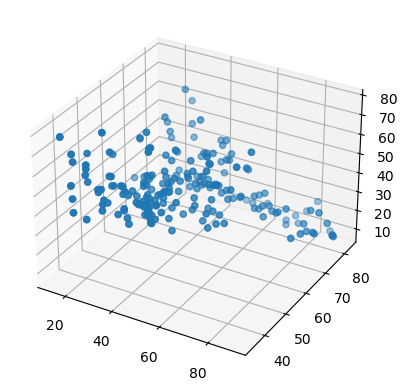

In [50]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(bor['average cpi'],bor['average db'],bor['average pfi'], cmap='Greens')

In [53]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(bor, x='average cpi', y='average db', z='average pfi',
              color='Status', hover_data=['Country_x','Country_y'])
fig.show()